In [1]:
import os

# Floor conditioned models
flux_floor_dir = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-10-18/10-30-43"
midiffusion_floor_dir = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-10-18/08-37-12"

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

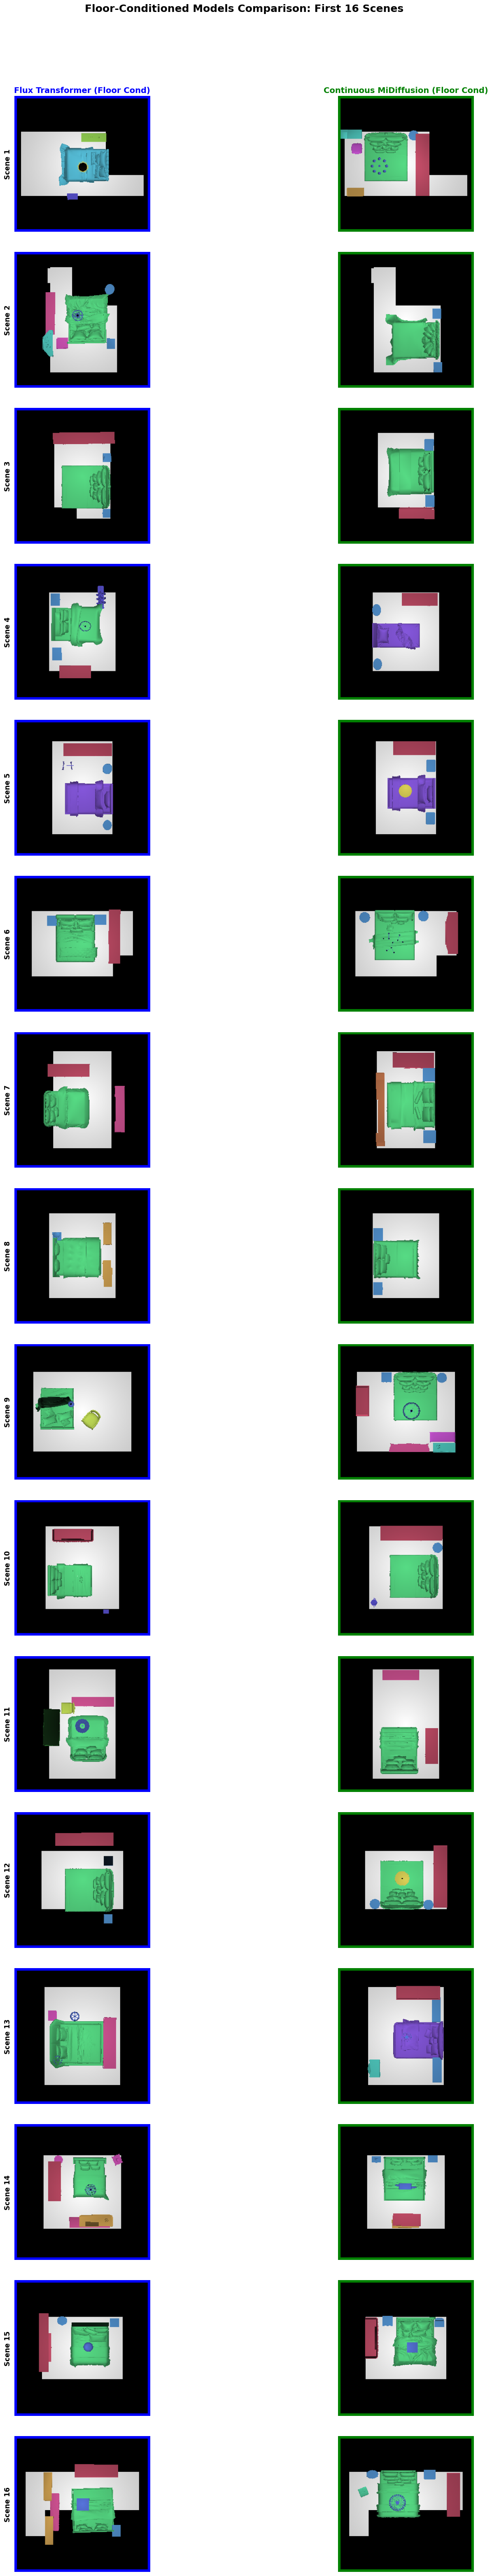

In [4]:
from PIL import ImageOps

def compare_floor_models(flux_dir, midiff_dir, num_images=16):
    """
    Compare first N images from Flux floor-conditioned vs MiDiffusion floor-conditioned models
    Shows them side by side in a grid (2 columns: Flux left, MiDiffusion right)
    """
    # Get sorted list of PNG files from both directories
    flux_files = sorted([f for f in os.listdir(flux_dir) if f.endswith(".png")])[:num_images]
    midiff_files = sorted([f for f in os.listdir(midiff_dir) if f.endswith(".png")])[:num_images]
    
    # Take minimum in case one has fewer images
    num_pairs = min(len(flux_files), len(midiff_files), num_images)
    
    # Create figure with 2 columns (Flux, MiDiffusion) and num_pairs rows
    fig, axes = plt.subplots(num_pairs, 2, figsize=(16, 4 * num_pairs))
    
    # Adjust spacing
    plt.subplots_adjust(wspace=0.05, hspace=0.15, left=0.02, right=0.98, top=0.96, bottom=0.02)
    
    border_width = 5
    border_color_flux = 'blue'  # Blue border for Flux
    border_color_midiff = 'green'  # Green border for MiDiffusion
    
    for i in range(num_pairs):
        # Load and display Flux image (left column)
        flux_img = Image.open(os.path.join(flux_dir, flux_files[i]))
        flux_img = ImageOps.expand(flux_img, border=border_width, fill=border_color_flux)
        axes[i, 0].imshow(flux_img)
        axes[i, 0].axis("off")
        if i == 0:
            axes[i, 0].set_title("Flux Transformer (Floor Cond)", fontsize=14, fontweight='bold', color='blue')
        
        # Load and display MiDiffusion image (right column)
        midiff_img = Image.open(os.path.join(midiff_dir, midiff_files[i]))
        midiff_img = ImageOps.expand(midiff_img, border=border_width, fill=border_color_midiff)
        axes[i, 1].imshow(midiff_img)
        axes[i, 1].axis("off")
        if i == 0:
            axes[i, 1].set_title("Continuous MiDiffusion (Floor Cond)", fontsize=14, fontweight='bold', color='green')
        
        # Add scene number on the left
        axes[i, 0].text(-0.02, 0.5, f"Scene {i+1}", 
                       transform=axes[i, 0].transAxes,
                       fontsize=12, fontweight='bold',
                       ha='right', va='center', rotation=90)
    
    fig.suptitle("Floor-Conditioned Models Comparison: First 16 Scenes", 
                 fontsize=18, fontweight='bold', y=0.995)
    
    plt.show()

# Run comparison
compare_floor_models(flux_floor_dir, midiffusion_floor_dir, num_images=16)